In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.sandwich_covariance import cov_hac
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Regression Analysis: Testing Hypotheses with Assumption Checks\n")
print("=" * 70)


Regression Analysis: Testing Hypotheses with Assumption Checks



In [24]:
# Load the cleaned merged dataset
df = pd.read_csv('cleaned_merged_data.csv', index_col='Date', parse_dates=True)

print("Loaded cleaned dataset:")
print(f"Shape: {df.shape}")
print(f"Date range: {df.index.min().date()} to {df.index.max().date()}")
print(f"\nColumns: {df.columns.tolist()}")
print("\nFirst few rows:")
print(df[['TSLA_Return', 'SPY_Return', 'VIX_Change', 'TSLA_Volume_Change']].head())


Loaded cleaned dataset:
Shape: (2821, 9)
Date range: 2010-06-30 to 2022-03-24

Columns: ['TSLA_Adj_Close', 'TSLA_Volume', 'SPY_Close', 'VIX_Close', 'TSLA_Return', 'SPY_Return', 'VIX_Change', 'TSLA_Volume_Log', 'TSLA_Volume_Change']

First few rows:
            TSLA_Return  SPY_Return  VIX_Change  TSLA_Volume_Change
Date                                                               
2010-06-30    -0.002515   -0.009545    0.410000           -0.087904
2010-07-01    -0.081723   -0.004467   -1.680000           -0.737735
2010-07-07    -0.019430    0.031010   -2.809999            0.007949
2010-07-08     0.099903    0.009847   -1.130001            0.108038
2010-07-09    -0.003442    0.007437   -0.730000           -0.643835


In [25]:
# ============================================================================
# HYPOTHESIS 1: Does Tesla's daily return depend on S&P 500's daily return?
# ============================================================================
print("\n" + "=" * 70)
print("HYPOTHESIS 1: Tesla's daily returns vs S&P 500 daily returns")
print("=" * 70)

# Prepare data
X1 = df[['SPY_Return']]
y1 = df['TSLA_Return']

# Add constant for intercept
X1_with_const = sm.add_constant(X1)

# Run OLS regression
model1 = OLS(y1, X1_with_const).fit()

print("\n--- Regression Results (Standard OLS) ---")
print(model1.summary())



HYPOTHESIS 1: Tesla's daily returns vs S&P 500 daily returns

--- Regression Results (Standard OLS) ---
                            OLS Regression Results                            
Dep. Variable:            TSLA_Return   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     536.0
Date:                Sat, 15 Nov 2025   Prob (F-statistic):          1.06e-108
Time:                        18:36:32   Log-Likelihood:                 6276.3
No. Observations:                2821   AIC:                        -1.255e+04
Df Residuals:                    2819   BIC:                        -1.254e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------


ASSUMPTION CHECKS FOR HYPOTHESIS 1

1. LINEARITY CHECK
----------------------------------------------------------------------


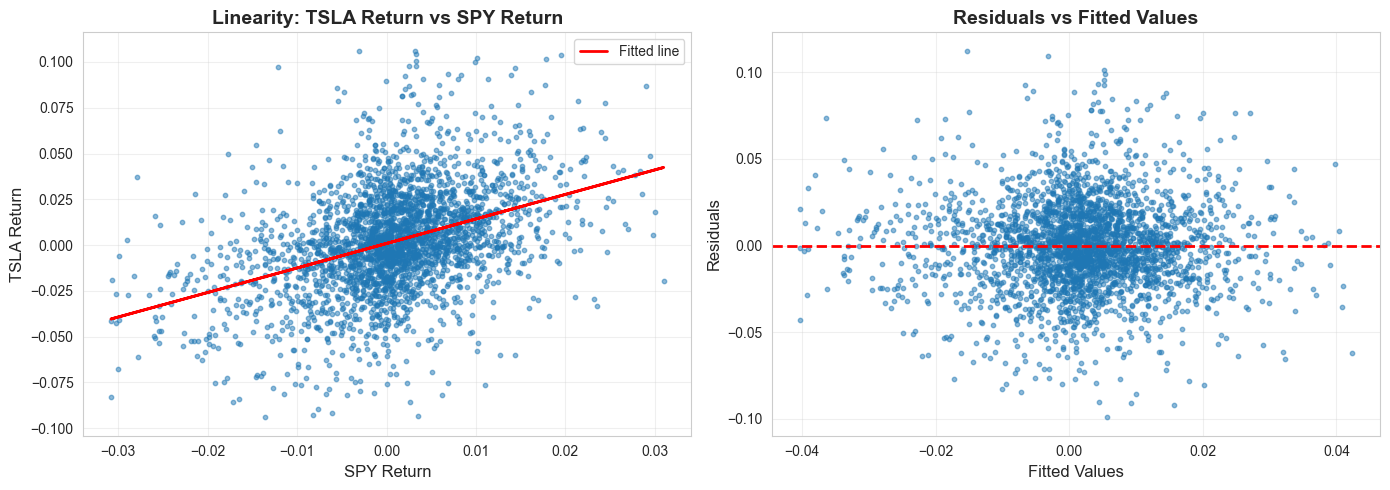

✓ Linearity appears reasonable if points follow the line pattern
✓ Residuals should be randomly scattered around zero


In [26]:
# ============================================================================
# ASSUMPTION CHECKS FOR HYPOTHESIS 1
# ============================================================================
print("\n" + "=" * 70)
print("ASSUMPTION CHECKS FOR HYPOTHESIS 1")
print("=" * 70)

# Get residuals and fitted values
residuals1 = model1.resid
fitted1 = model1.fittedvalues

# 1. LINEARITY CHECK: Scatter plot
print("\n1. LINEARITY CHECK")
print("-" * 70)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot: TSLA_Return vs SPY_Return
axes[0].scatter(X1['SPY_Return'], y1, alpha=0.5, s=10)
axes[0].plot(X1['SPY_Return'], fitted1, 'r-', linewidth=2, label='Fitted line')
axes[0].set_xlabel('SPY Return', fontsize=12)
axes[0].set_ylabel('TSLA Return', fontsize=12)
axes[0].set_title('Linearity: TSLA Return vs SPY Return', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuals vs Fitted
axes[1].scatter(fitted1, residuals1, alpha=0.5, s=10)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Fitted Values', fontsize=12)
axes[1].set_ylabel('Residuals', fontsize=12)
axes[1].set_title('Residuals vs Fitted Values', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Linearity appears reasonable if points follow the line pattern")
print("✓ Residuals should be randomly scattered around zero")



2. NORMALITY CHECK (Q-Q Plot)
----------------------------------------------------------------------


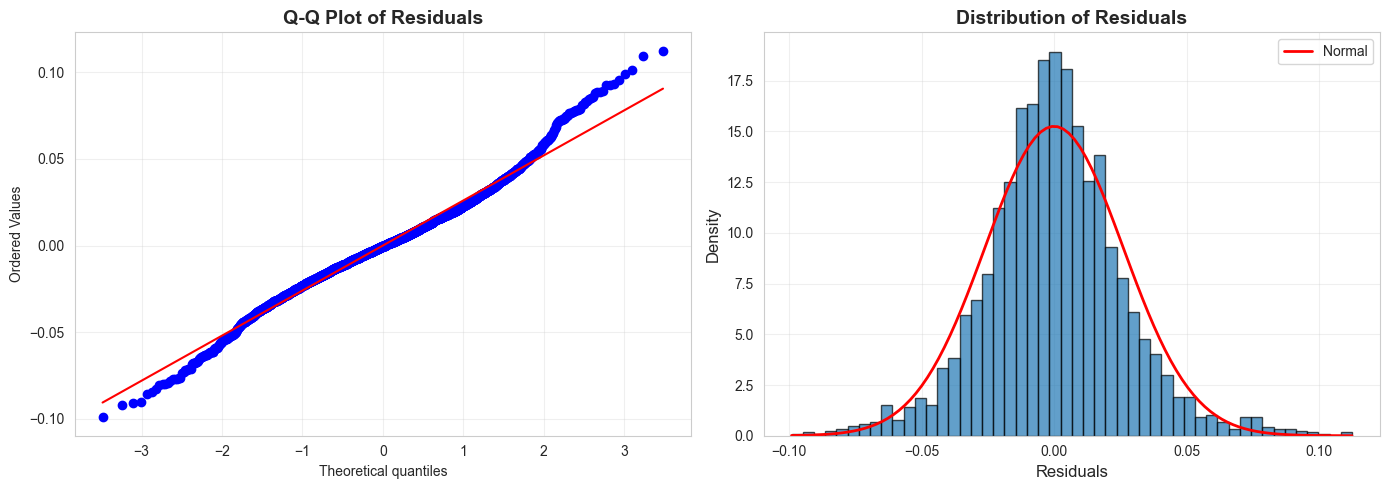


Shapiro-Wilk Test:
  Statistic: 0.9846
  p-value: 0.000000
  ✗ REJECT normality (p < 0.05) - Residuals are NOT normally distributed


In [27]:
# 2. NORMALITY CHECK: Q-Q Plot
print("\n2. NORMALITY CHECK (Q-Q Plot)")
print("-" * 70)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Q-Q plot
stats.probplot(residuals1, dist="norm", plot=axes[0])
axes[0].set_title('Q-Q Plot of Residuals', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Histogram of residuals
axes[1].hist(residuals1, bins=50, density=True, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Residuals', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].set_title('Distribution of Residuals', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Add normal curve overlay
mu, sigma = residuals1.mean(), residuals1.std()
x = np.linspace(residuals1.min(), residuals1.max(), 100)
axes[1].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal')
axes[1].legend()

plt.tight_layout()
plt.show()

# Shapiro-Wilk test for normality
shapiro_stat, shapiro_p = stats.shapiro(residuals1)
print(f"\nShapiro-Wilk Test:")
print(f"  Statistic: {shapiro_stat:.4f}")
print(f"  p-value: {shapiro_p:.6f}")
if shapiro_p < 0.05:
    print("  ✗ REJECT normality (p < 0.05) - Residuals are NOT normally distributed")
    normality1 = False
else:
    print("  ✓ FAIL TO REJECT normality (p >= 0.05) - Residuals appear normally distributed")
    normality1 = True


In [28]:
# 3. HETEROSCEDASTICITY CHECK: Breusch-Pagan Test
print("\n3. HETEROSCEDASTICITY CHECK (Breusch-Pagan Test)")
print("-" * 70)

# Breusch-Pagan test
bp_lm, bp_pvalue, bp_fvalue, bp_f_pvalue = het_breuschpagan(residuals1, X1_with_const)
print(f"Breusch-Pagan Test:")
print(f"  LM Statistic: {bp_lm:.4f}")
print(f"  p-value: {bp_pvalue:.6f}")
if bp_pvalue < 0.05:
    print("  ✗ REJECT homoscedasticity (p < 0.05) - HETEROSCEDASTICITY detected")
    heteroscedasticity1 = True
else:
    print("  ✓ FAIL TO REJECT homoscedasticity (p >= 0.05) - Constant variance appears OK")
    heteroscedasticity1 = False

# Visual check: Residuals vs Fitted (already shown, but emphasize)
print("\nVisual Check: Look at Residuals vs Fitted plot above")
print("  - Random scatter = homoscedasticity (good)")
print("  - Funnel/pattern = heteroscedasticity (bad)")

# 4. AUTOCORRELATION CHECK: Durbin-Watson Test
print("\n4. AUTOCORRELATION CHECK (Durbin-Watson Test)")
print("-" * 70)

dw_stat = durbin_watson(residuals1)
print(f"Durbin-Watson Statistic: {dw_stat:.4f}")
print(f"\nInterpretation:")
print(f"  - DW ≈ 2.0: No autocorrelation")
print(f"  - DW < 1.5: Positive autocorrelation (likely)")
print(f"  - DW > 2.5: Negative autocorrelation (unlikely)")

if dw_stat < 1.5:
    print(f"  ✗ POSITIVE AUTOCORRELATION detected (DW = {dw_stat:.4f} < 1.5)")
    autocorrelation1 = True
elif dw_stat > 2.5:
    print(f"  ✗ NEGATIVE AUTOCORRELATION detected (DW = {dw_stat:.4f} > 2.5)")
    autocorrelation1 = True
else:
    print(f"  ✓ No significant autocorrelation (DW = {dw_stat:.4f} ≈ 2.0)")
    autocorrelation1 = False



3. HETEROSCEDASTICITY CHECK (Breusch-Pagan Test)
----------------------------------------------------------------------
Breusch-Pagan Test:
  LM Statistic: 0.0187
  p-value: 0.891172
  ✓ FAIL TO REJECT homoscedasticity (p >= 0.05) - Constant variance appears OK

Visual Check: Look at Residuals vs Fitted plot above
  - Random scatter = homoscedasticity (good)
  - Funnel/pattern = heteroscedasticity (bad)

4. AUTOCORRELATION CHECK (Durbin-Watson Test)
----------------------------------------------------------------------
Durbin-Watson Statistic: 1.9851

Interpretation:
  - DW ≈ 2.0: No autocorrelation
  - DW < 1.5: Positive autocorrelation (likely)
  - DW > 2.5: Negative autocorrelation (unlikely)
  ✓ No significant autocorrelation (DW = 1.9851 ≈ 2.0)


In [29]:
# 5. SUMMARY AND ROBUST STANDARD ERRORS (if needed)
print("\n" + "=" * 70)
print("ASSUMPTION SUMMARY FOR HYPOTHESIS 1")
print("=" * 70)

# Check all assumptions - use robust SE if ANY critical assumption fails
# Critical assumptions: heteroscedasticity, autocorrelation, or normality
assumptions_failed = heteroscedasticity1 or autocorrelation1 or (not normality1)

print("\nAssumption Status:")
print(f"  Normality: {'✗ FAILED' if not normality1 else '✓ PASSED'}")
print(f"  Homoscedasticity: {'✗ FAILED' if heteroscedasticity1 else '✓ PASSED'}")
print(f"  No Autocorrelation: {'✗ FAILED' if autocorrelation1 else '✓ PASSED'}")

if assumptions_failed:
    print("\n✗ SOME ASSUMPTIONS FAILED - Using Newey-West (HAC) Robust Standard Errors")
    print("   (Robust SE are appropriate when normality, heteroscedasticity, or autocorrelation fail)")
    print("\nApplying Newey-West HAC (Heteroscedasticity and Autocorrelation Consistent) standard errors...")
    
    # Calculate Newey-West HAC covariance matrix
    # Using automatic lag selection (maxlag = floor(4*(n/100)^(2/9)))
    n = len(residuals1)
    maxlag = int(np.floor(4 * (n/100)**(2/9)))
    
    hac_cov = cov_hac(model1, nlags=maxlag)
    model1_hac = model1
    model1_hac.cov_params_default = hac_cov
    
    print(f"\n--- Regression Results with Newey-West HAC Robust Standard Errors ---")
    print(f"(Max lag for HAC: {maxlag})")
    # Create a new model with HAC covariance for display
    model1_hac_display = OLS(y1, X1_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': maxlag})
    print(model1_hac_display.summary())
    
    print("\n" + "=" * 70)
    print("FINAL RESULTS FOR HYPOTHESIS 1 (with Robust SE)")
    print("=" * 70)
    print(f"\nCoefficient on SPY_Return: {model1_hac.params['SPY_Return']:.4f}")
    print(f"Robust Standard Error: {np.sqrt(hac_cov[1,1]):.6f}")
    robust_t_stat = model1_hac.params['SPY_Return'] / np.sqrt(hac_cov[1,1])
    print(f"Robust t-statistic: {robust_t_stat:.4f}")
    print(f"R-squared: {model1_hac.rsquared:.4f}")
    
    # Calculate p-value for robust t-statistic (two-tailed test)
    robust_p_value = 2 * (1 - stats.norm.cdf(abs(robust_t_stat)))
    print(f"Robust p-value: {robust_p_value:.6f}")
    
    if abs(robust_t_stat) > 1.96:
        print("\n✓ CONCLUSION: Tesla's returns ARE significantly correlated with SPY returns")
        print(f"  (p = {robust_p_value:.6f} < 0.05 with robust standard errors)")
        print(f"  Interpretation: For every 1% change in SPY return, Tesla return changes by {model1_hac.params['SPY_Return']:.2%}")
    else:
        print("\n✗ CONCLUSION: Tesla's returns are NOT significantly correlated with SPY returns")
        print(f"  (p = {robust_p_value:.6f} >= 0.05 with robust standard errors)")
        
else:
    print("\n✓ ALL ASSUMPTIONS PASSED - Standard OLS results are reliable")
    print("\n" + "=" * 70)
    print("FINAL RESULTS FOR HYPOTHESIS 1 (Standard OLS)")
    print("=" * 70)
    print(f"\nCoefficient on SPY_Return: {model1.params['SPY_Return']:.4f}")
    print(f"Standard Error: {model1.bse['SPY_Return']:.6f}")
    print(f"t-statistic: {model1.tvalues['SPY_Return']:.4f}")
    print(f"p-value: {model1.pvalues['SPY_Return']:.6f}")
    print(f"R-squared: {model1.rsquared:.4f}")
    
    if model1.pvalues['SPY_Return'] < 0.05:
        print("\n✓ CONCLUSION: Tesla's returns ARE significantly correlated with SPY returns")
        print(f"  (p = {model1.pvalues['SPY_Return']:.6f} < 0.05)")
        print(f"  Interpretation: For every 1% change in SPY return, Tesla return changes by {model1.params['SPY_Return']:.2%}")
    else:
        print("\n✗ CONCLUSION: Tesla's returns are NOT significantly correlated with SPY returns")
        print(f"  (p = {model1.pvalues['SPY_Return']:.6f} >= 0.05)")



ASSUMPTION SUMMARY FOR HYPOTHESIS 1

Assumption Status:
  Normality: ✗ FAILED
  Homoscedasticity: ✓ PASSED
  No Autocorrelation: ✓ PASSED

✗ SOME ASSUMPTIONS FAILED - Using Newey-West (HAC) Robust Standard Errors
   (Robust SE are appropriate when normality, heteroscedasticity, or autocorrelation fail)

Applying Newey-West HAC (Heteroscedasticity and Autocorrelation Consistent) standard errors...

--- Regression Results with Newey-West HAC Robust Standard Errors ---
(Max lag for HAC: 8)
                            OLS Regression Results                            
Dep. Variable:            TSLA_Return   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     436.3
Date:                Sat, 15 Nov 2025   Prob (F-statistic):           3.37e-90
Time:                        18:36:32   Log-Likelihood:                 6276.3
No. Observations:                

In [30]:
# ============================================================================
# HYPOTHESIS 2: Do volume and VIX explain Tesla returns beyond market movement?
# ============================================================================
print("\n\n" + "=" * 70)
print("HYPOTHESIS 2: Volume and VIX explaining Tesla returns")
print("=" * 70)

# Prepare data
X2 = df[['SPY_Return', 'VIX_Change', 'TSLA_Volume_Change']]
y2 = df['TSLA_Return']

# Add constant for intercept
X2_with_const = sm.add_constant(X2)

# Run OLS regression
model2 = OLS(y2, X2_with_const).fit()

print("\n--- Regression Results (Standard OLS) ---")
print(model2.summary())




HYPOTHESIS 2: Volume and VIX explaining Tesla returns

--- Regression Results (Standard OLS) ---
                            OLS Regression Results                            
Dep. Variable:            TSLA_Return   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     185.2
Date:                Sat, 15 Nov 2025   Prob (F-statistic):          1.32e-109
Time:                        18:36:32   Log-Likelihood:                 6284.7
No. Observations:                2821   AIC:                        -1.256e+04
Df Residuals:                    2817   BIC:                        -1.254e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------


ASSUMPTION CHECKS FOR HYPOTHESIS 2

0. MULTICOLLINEARITY CHECK (Variance Inflation Factor)
----------------------------------------------------------------------
          Variable      VIF
        SPY_Return 2.860519
        VIX_Change 2.872428
TSLA_Volume_Change 1.007075

Interpretation:
  - VIF < 5: Low multicollinearity (good)
  - VIF 5-10: Moderate multicollinearity (caution)
  - VIF > 10: High multicollinearity (problem)

  ✓ No significant multicollinearity (all VIF < 10)

1. LINEARITY CHECK
----------------------------------------------------------------------


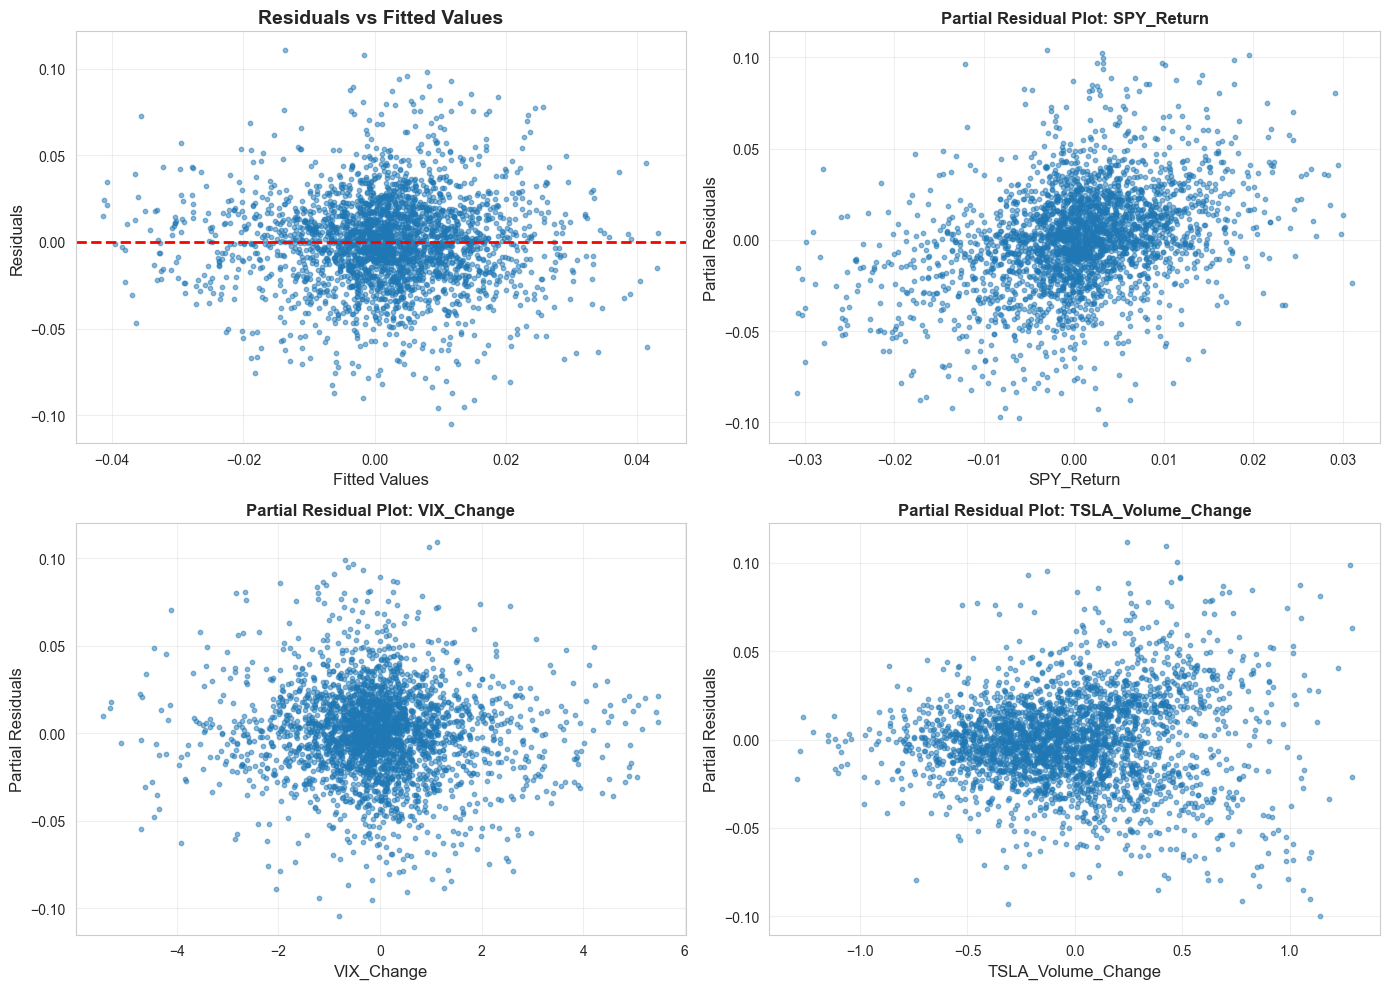

✓ Check plots for linearity patterns


In [31]:
# ============================================================================
# ASSUMPTION CHECKS FOR HYPOTHESIS 2
# ============================================================================
print("\n" + "=" * 70)
print("ASSUMPTION CHECKS FOR HYPOTHESIS 2")
print("=" * 70)

# Get residuals and fitted values
residuals2 = model2.resid
fitted2 = model2.fittedvalues

# 0. MULTICOLLINEARITY CHECK: VIF
print("\n0. MULTICOLLINEARITY CHECK (Variance Inflation Factor)")
print("-" * 70)

vif_data = pd.DataFrame()
vif_data["Variable"] = X2.columns
vif_data["VIF"] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]

print(vif_data.to_string(index=False))
print("\nInterpretation:")
print("  - VIF < 5: Low multicollinearity (good)")
print("  - VIF 5-10: Moderate multicollinearity (caution)")
print("  - VIF > 10: High multicollinearity (problem)")

high_vif = (vif_data['VIF'] > 10).any()
if high_vif:
    print(f"\n  ✗ HIGH MULTICOLLINEARITY detected (VIF > 10)")
    multicollinearity2 = True
else:
    print(f"\n  ✓ No significant multicollinearity (all VIF < 10)")
    multicollinearity2 = False

# 1. LINEARITY CHECK
print("\n1. LINEARITY CHECK")
print("-" * 70)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Residuals vs Fitted
axes[0, 0].scatter(fitted2, residuals2, alpha=0.5, s=10)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Fitted Values', fontsize=12)
axes[0, 0].set_ylabel('Residuals', fontsize=12)
axes[0, 0].set_title('Residuals vs Fitted Values', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Partial regression plots for each variable
for idx, var in enumerate(['SPY_Return', 'VIX_Change', 'TSLA_Volume_Change']):
    row = (idx + 1) // 2
    col = (idx + 1) % 2
    if row < 2 and col < 2:
        # Partial residual plot
        axes[row, col].scatter(X2[var], residuals2 + model2.params[var] * X2[var], alpha=0.5, s=10)
        axes[row, col].set_xlabel(var, fontsize=12)
        axes[row, col].set_ylabel('Partial Residuals', fontsize=12)
        axes[row, col].set_title(f'Partial Residual Plot: {var}', fontsize=12, fontweight='bold')
        axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print("✓ Check plots for linearity patterns")



2. NORMALITY CHECK (Q-Q Plot)
----------------------------------------------------------------------


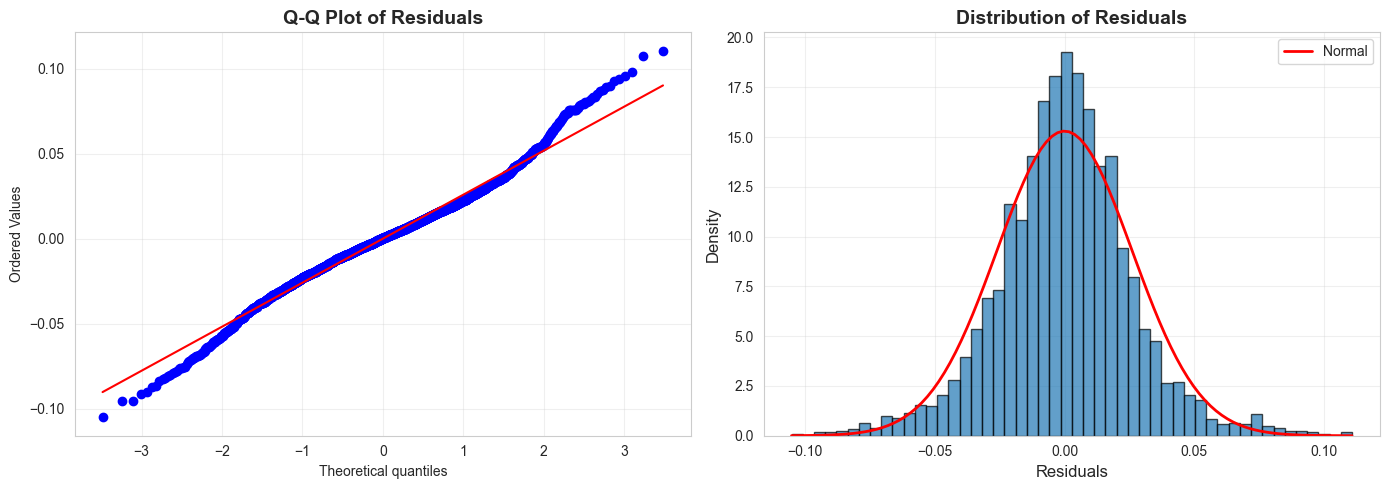


Shapiro-Wilk Test:
  Statistic: 0.9848
  p-value: 0.000000
  ✗ REJECT normality (p < 0.05) - Residuals are NOT normally distributed

3. HETEROSCEDASTICITY CHECK (Breusch-Pagan Test)
----------------------------------------------------------------------
Breusch-Pagan Test:
  LM Statistic: 330.6911
  p-value: 0.000000
  ✗ REJECT homoscedasticity (p < 0.05) - HETEROSCEDASTICITY detected

4. AUTOCORRELATION CHECK (Durbin-Watson Test)
----------------------------------------------------------------------
Durbin-Watson Statistic: 1.9844

Interpretation:
  - DW ≈ 2.0: No autocorrelation
  - DW < 1.5: Positive autocorrelation (likely)
  - DW > 2.5: Negative autocorrelation (unlikely)
  ✓ No significant autocorrelation (DW = 1.9844 ≈ 2.0)


In [32]:
# 2. NORMALITY CHECK: Q-Q Plot
print("\n2. NORMALITY CHECK (Q-Q Plot)")
print("-" * 70)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

stats.probplot(residuals2, dist="norm", plot=axes[0])
axes[0].set_title('Q-Q Plot of Residuals', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].hist(residuals2, bins=50, density=True, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Residuals', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].set_title('Distribution of Residuals', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

mu, sigma = residuals2.mean(), residuals2.std()
x = np.linspace(residuals2.min(), residuals2.max(), 100)
axes[1].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal')
axes[1].legend()

plt.tight_layout()
plt.show()

shapiro_stat2, shapiro_p2 = stats.shapiro(residuals2)
print(f"\nShapiro-Wilk Test:")
print(f"  Statistic: {shapiro_stat2:.4f}")
print(f"  p-value: {shapiro_p2:.6f}")
if shapiro_p2 < 0.05:
    print("  ✗ REJECT normality (p < 0.05) - Residuals are NOT normally distributed")
else:
    print("  ✓ FAIL TO REJECT normality (p >= 0.05) - Residuals appear normally distributed")

# 3. HETEROSCEDASTICITY CHECK
print("\n3. HETEROSCEDASTICITY CHECK (Breusch-Pagan Test)")
print("-" * 70)

bp_lm2, bp_pvalue2, bp_fvalue2, bp_f_pvalue2 = het_breuschpagan(residuals2, X2_with_const)
print(f"Breusch-Pagan Test:")
print(f"  LM Statistic: {bp_lm2:.4f}")
print(f"  p-value: {bp_pvalue2:.6f}")
if bp_pvalue2 < 0.05:
    print("  ✗ REJECT homoscedasticity (p < 0.05) - HETEROSCEDASTICITY detected")
    heteroscedasticity2 = True
else:
    print("  ✓ FAIL TO REJECT homoscedasticity (p >= 0.05) - Constant variance appears OK")
    heteroscedasticity2 = False

# 4. AUTOCORRELATION CHECK
print("\n4. AUTOCORRELATION CHECK (Durbin-Watson Test)")
print("-" * 70)

dw_stat2 = durbin_watson(residuals2)
print(f"Durbin-Watson Statistic: {dw_stat2:.4f}")
print(f"\nInterpretation:")
print(f"  - DW ≈ 2.0: No autocorrelation")
print(f"  - DW < 1.5: Positive autocorrelation (likely)")
print(f"  - DW > 2.5: Negative autocorrelation (unlikely)")

if dw_stat2 < 1.5:
    print(f"  ✗ POSITIVE AUTOCORRELATION detected (DW = {dw_stat2:.4f} < 1.5)")
    autocorrelation2 = True
elif dw_stat2 > 2.5:
    print(f"  ✗ NEGATIVE AUTOCORRELATION detected (DW = {dw_stat2:.4f} > 2.5)")
    autocorrelation2 = True
else:
    print(f"  ✓ No significant autocorrelation (DW = {dw_stat2:.4f} ≈ 2.0)")
    autocorrelation2 = False


In [33]:
# 5. SUMMARY AND ROBUST STANDARD ERRORS (if needed)
print("\n" + "=" * 70)
print("ASSUMPTION SUMMARY FOR HYPOTHESIS 2")
print("=" * 70)

assumptions_failed2 = heteroscedasticity2 or autocorrelation2

if assumptions_failed2:
    print("\n✗ SOME ASSUMPTIONS FAILED - Using Newey-West (HAC) Robust Standard Errors")
    print("\nApplying Newey-West HAC (Heteroscedasticity and Autocorrelation Consistent) standard errors...")
    
    n2 = len(residuals2)
    maxlag2 = int(np.floor(4 * (n2/100)**(2/9)))
    
    hac_cov2 = cov_hac(model2, nlags=maxlag2)
    model2_hac = model2
    model2_hac.cov_params_default = hac_cov2
    
    print(f"\n--- Regression Results with Newey-West HAC Robust Standard Errors ---")
    print(f"(Max lag for HAC: {maxlag2})")
    # Create a new model with HAC covariance for display
    model2_hac_display = OLS(y2, X2_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': maxlag2})
    print(model2_hac_display.summary())
    
    print("\n" + "=" * 70)
    print("FINAL RESULTS FOR HYPOTHESIS 2 (with Robust SE)")
    print("=" * 70)
    
    print("\nCoefficients (with Robust Standard Errors):")
    for var in ['SPY_Return', 'VIX_Change', 'TSLA_Volume_Change']:
        idx = X2_with_const.columns.get_loc(var)
        coef = model2_hac.params[var]
        se = np.sqrt(hac_cov2[idx, idx])
        t_stat = coef / se
        print(f"\n  {var}:")
        print(f"    Coefficient: {coef:.6f}")
        print(f"    Robust SE: {se:.6f}")
        print(f"    t-statistic: {t_stat:.4f}")
        if abs(t_stat) > 1.96:
            print(f"    ✓ Significant (p < 0.05)")
        else:
            print(f"    ✗ Not significant (p >= 0.05)")
    
    print(f"\nR-squared: {model2_hac.rsquared:.4f}")
    print(f"Adjusted R-squared: {model2_hac.rsquared_adj:.4f}")
    
    print("\n" + "-" * 70)
    print("CONCLUSION FOR HYPOTHESIS 2:")
    print("-" * 70)
    
    # Check significance of VIX and Volume beyond SPY
    vix_idx = X2_with_const.columns.get_loc('VIX_Change')
    vol_idx = X2_with_const.columns.get_loc('TSLA_Volume_Change')
    
    vix_significant = abs(model2_hac.params['VIX_Change'] / np.sqrt(hac_cov2[vix_idx, vix_idx])) > 1.96
    vol_significant = abs(model2_hac.params['TSLA_Volume_Change'] / np.sqrt(hac_cov2[vol_idx, vol_idx])) > 1.96
    
    if vix_significant or vol_significant:
        print("✓ Volume and/or VIX DO significantly contribute to explaining Tesla's returns")
        print("  beyond market movement (SPY)")
    else:
        print("✗ Volume and VIX do NOT significantly contribute to explaining Tesla's returns")
        print("  beyond market movement (SPY)")
        
else:
    print("\n✓ ALL ASSUMPTIONS PASSED - Standard OLS results are reliable")
    print("\n" + "=" * 70)
    print("FINAL RESULTS FOR HYPOTHESIS 2 (Standard OLS)")
    print("=" * 70)
    
    print("\nCoefficients:")
    for var in ['SPY_Return', 'VIX_Change', 'TSLA_Volume_Change']:
        print(f"\n  {var}:")
        print(f"    Coefficient: {model2.params[var]:.6f}")
        print(f"    Standard Error: {model2.bse[var]:.6f}")
        print(f"    t-statistic: {model2.tvalues[var]:.4f}")
        print(f"    p-value: {model2.pvalues[var]:.6f}")
        if model2.pvalues[var] < 0.05:
            print(f"    ✓ Significant (p < 0.05)")
        else:
            print(f"    ✗ Not significant (p >= 0.05)")
    
    print(f"\nR-squared: {model2.rsquared:.4f}")
    print(f"Adjusted R-squared: {model2.rsquared_adj:.4f}")
    
    print("\n" + "-" * 70)
    print("CONCLUSION FOR HYPOTHESIS 2:")
    print("-" * 70)
    
    if model2.pvalues['VIX_Change'] < 0.05 or model2.pvalues['TSLA_Volume_Change'] < 0.05:
        print("✓ Volume and/or VIX DO significantly contribute to explaining Tesla's returns")
        print("  beyond market movement (SPY)")
    else:
        print("✗ Volume and VIX do NOT significantly contribute to explaining Tesla's returns")
        print("  beyond market movement (SPY)")

print("\n" + "=" * 70)
print("ANALYSIS COMPLETE")
print("=" * 70)



ASSUMPTION SUMMARY FOR HYPOTHESIS 2

✗ SOME ASSUMPTIONS FAILED - Using Newey-West (HAC) Robust Standard Errors

Applying Newey-West HAC (Heteroscedasticity and Autocorrelation Consistent) standard errors...

--- Regression Results with Newey-West HAC Robust Standard Errors ---
(Max lag for HAC: 8)
                            OLS Regression Results                            
Dep. Variable:            TSLA_Return   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     158.4
Date:                Sat, 15 Nov 2025   Prob (F-statistic):           7.60e-95
Time:                        18:36:33   Log-Likelihood:                 6284.7
No. Observations:                2821   AIC:                        -1.256e+04
Df Residuals:                    2817   BIC:                        -1.254e+04
Df Model:                           3                               